Epoch: 0, Loss: 0.3345
Epoch: 1, Loss: 0.3099
Epoch: 2, Loss: 0.2827
Epoch: 3, Loss: 0.2497
Epoch: 4, Loss: 0.2205
Epoch: 5, Loss: 0.2041
Epoch: 6, Loss: 0.1780
Epoch: 7, Loss: 0.1645
Epoch: 8, Loss: 0.1466
Epoch: 9, Loss: 0.1381


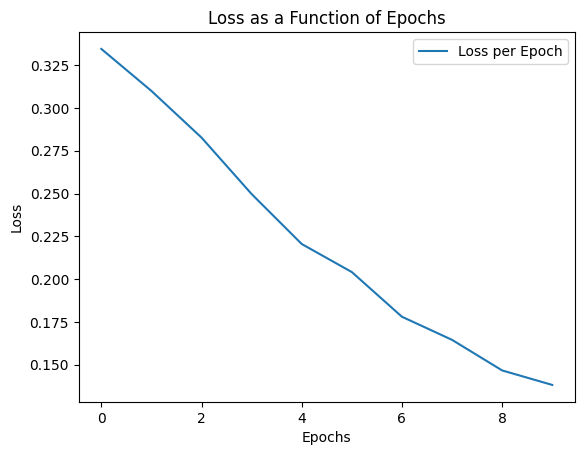

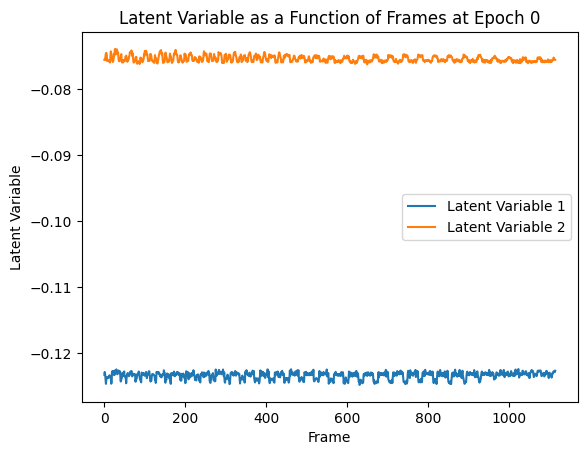

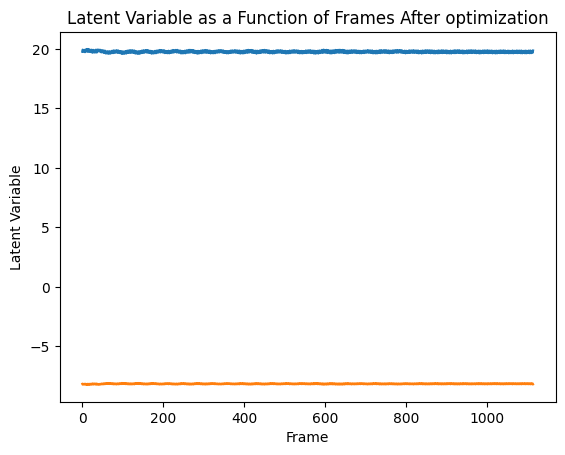

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from data_processing.data_processing2 import images_tensor

class ConvNetAutoencoder_basic(nn.Module):
    def __init__(self, input_shape):
        super(ConvNetAutoencoder_basic, self).__init__()
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )
        # Output Dimension = ((Input dimension +2*padding - kernel_size)/stride) + 1
        # stride is how much we shift after each filter 
        # padding is adding zeros around the edges of your matrix before applying the filter
        # Final dimension is (64,69,25)

        #Dynamically calculate the output shape of the encoder conv layers
        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2),  # Assuming a 2-dimensional latent space
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def _get_conv_output(self, shape):
        bs = 1  # Batch size of 1 for testing output shape
        input_tensor = torch.randn(bs, *shape)  # Generate a random tensor without Variable
        with torch.no_grad():  # Disable gradient tracking since this is only for shape calculation
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]  # Store the shape after the last conv layer
        n_size = output_feat.detach().flatten(start_dim=1).size(1)  # Compute flattened size safely
        self.num_flat_features = n_size

    def forward(self, x):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1) #Flattening
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()  # Store latent variables before decoding
        x = self.decoder_fc_layers(x)
        #Use stored shape for dynamic reshaping
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        return x,latent_vars


images_tensor = images_tensor


model = ConvNetAutoencoder_basic(input_shape=(1, 200, 560))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
losses = []
patience = 5
min_delta = 0.01  
latent_epoch_data = []
converged = False

for epoch in range(num_epochs):
    if converged:
        break
    model.train()
    optimizer.zero_grad()
    reconstructed, latent_vars = model(images_tensor)
    loss = loss_fn(reconstructed, images_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f"Epoch: {epoch}, Loss: {loss.item():.4f}")

    if epoch > 0 and (losses[-2] - losses[-1] < min_delta):
        if patience > 0:
            patience -= 1
        else:
            print("Early stopping as the model has converged.")
            converged=True

    if epoch % 50 == 0:
        latent_epoch_data.append(latent_vars.detach().cpu().numpy())



latent_values = []

model.eval()
# Forward pass to get the latent variable
with torch.no_grad():
    xe = model.encoder_conv_layers(images_tensor)
    xe = xe.view(xe.size(0), -1)
    latent_variable = model.encoder_fc_layers(xe)

# Convert the lists to numpy arrays for plotting
latent_values = latent_variable.numpy() 


plt.plot(losses, label='Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as a Function of Epochs')
plt.legend()
plt.show()


for index, latent_vars_at_epoch in enumerate(latent_epoch_data):
    plt.figure()
    for var_idx in range(latent_vars_at_epoch.shape[1]):  
        plt.plot(latent_vars_at_epoch[:, var_idx], label=f'Latent Variable {var_idx + 1}')
    plt.xlabel('Frame')
    plt.ylabel('Latent Variable')
    plt.title(f'Latent Variable as a Function of Frames at Epoch {index * 50}')
    plt.legend()
    plt.show()



# Plot the latent variable as a function of epochs
plt.plot(latent_values)
plt.xlabel('Frame')
plt.ylabel('Latent Variable')
plt.title('Latent Variable as a Function of Frames After optimization')
plt.show()



These are results for when we dont include any physics informed losses our results dont really make sense quantitatevly however they do make sense qualitatively we have oscillations which makes sense since both x and v should be oscillating for our system. (as you can see overfitting is occuring thats why we barely have any oscillations after optimaztion)

Epoch: 0, Total Loss: 0.5737
Epoch: 1, Total Loss: 27.1742
Epoch: 2, Total Loss: 1.3928
Epoch: 3, Total Loss: 0.5473
Epoch: 4, Total Loss: 0.5854
Epoch: 5, Total Loss: 0.6127
Epoch: 6, Total Loss: 0.5388
Epoch: 7, Total Loss: 0.4964
Epoch: 8, Total Loss: 0.4879
Epoch: 9, Total Loss: 0.4776
Epoch: 10, Total Loss: 0.3785
Epoch: 11, Total Loss: 0.3037
Epoch: 12, Total Loss: 0.2594
Epoch: 13, Total Loss: 0.2147
Epoch: 14, Total Loss: 0.2576
Epoch: 15, Total Loss: 0.1907
Epoch: 16, Total Loss: 0.1477
Epoch: 17, Total Loss: 0.1137
Epoch: 18, Total Loss: 0.1219
Early stopping as the model has converged.


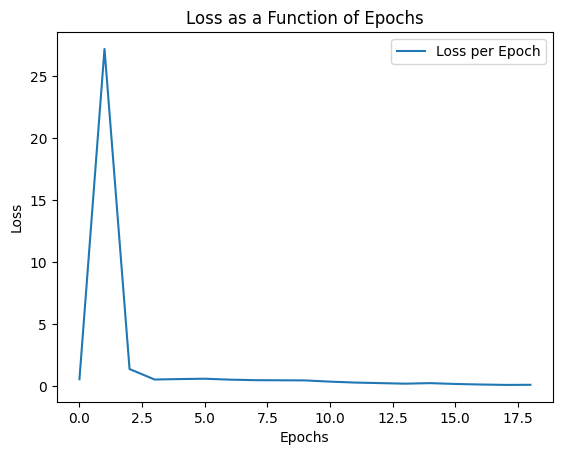

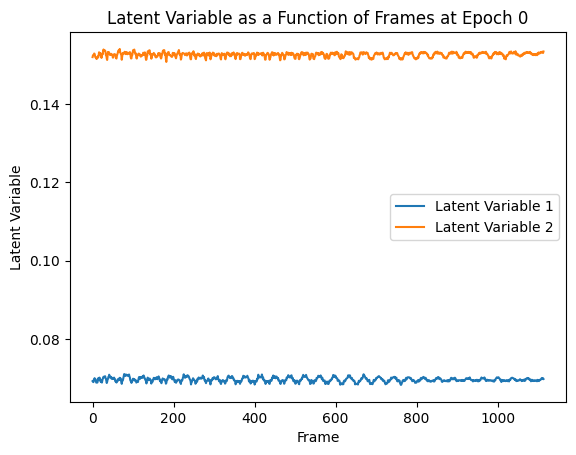

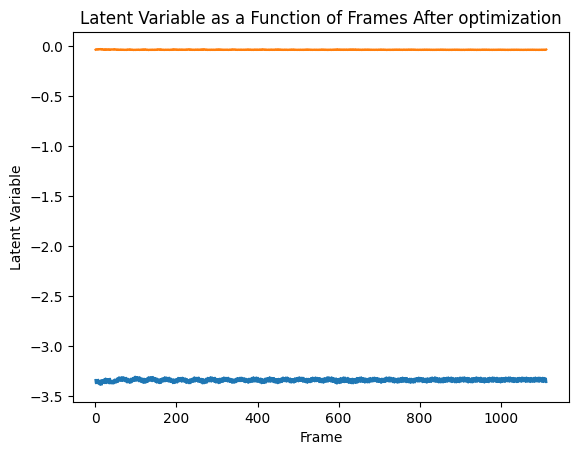

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from data_processing.data_processing2 import images_tensor

class ConvNetAutoencoder_basic(nn.Module):
    def __init__(self, input_shape):
        super(ConvNetAutoencoder_basic, self).__init__()
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )
        # Output Dimension = ((Input dimension +2*padding - kernel_size)/stride) + 1
        # stride is how much we shift after each filter 
        # padding is adding zeros around the edges of your matrix before applying the filter
        # Final dimension is (64,69,25)

        #Dynamically calculate the output shape of the encoder conv layers
        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2),  # Assuming a 2-dimensional latent space
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def _get_conv_output(self, shape):
        bs = 1  # Batch size of 1 for testing output shape
        input_tensor = torch.randn(bs, *shape)  # Generate a random tensor without Variable
        with torch.no_grad():  # Disable gradient tracking since this is only for shape calculation
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]  # Store the shape after the last conv layer
        n_size = output_feat.detach().flatten(start_dim=1).size(1)  # Compute flattened size safely
        self.num_flat_features = n_size

    def forward(self, x):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1) #Flattening
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()  # Store latent variables before decoding
        x = self.decoder_fc_layers(x)
        #Use stored shape for dynamic reshaping
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        return x,latent_vars


images_tensor = images_tensor


model = ConvNetAutoencoder_basic(input_shape=(1, 200, 560))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
losses = []
patience = 5
min_delta = 0.01  
latent_epoch_data = []
converged = False


def physics_informed_loss(x, v, lambda_phys=0.3):
    # Example: Assume v should be the derivative of x with respect to some time factor
    # Here we use a simple finite difference approximation (x[n+1] - x[n]) as a placeholder.
    # You can modify this according to the actual physical relation you need to enforce.
    dx_dt_estimated = x[1:] - x[:-1]  # Simple finite difference
    phys_loss = F.mse_loss(v[:-1], dx_dt_estimated)  # MSE between estimated derivative and velocity
    return lambda_phys * phys_loss

for epoch in range(num_epochs):
    if converged:
        break
    model.train()
    optimizer.zero_grad()

    # Forward pass through the model
    reconstructed, latent_vars = model(images_tensor)

    # Standard reconstruction loss
    reconstruction_loss = loss_fn(reconstructed, images_tensor)

    # Extract latent variables assumed as [x, v]
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    # Calculate the physics-informed loss
    phys_loss = physics_informed_loss(x, v)

    # Total loss is the sum of reconstruction loss and physics-informed loss
    total_loss = 0.7*reconstruction_loss + phys_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    losses.append(total_loss.item())
    print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.4f}")

    # Early stopping logic
    if epoch > 0 and (losses[-2] - losses[-1] < min_delta):
        if patience > 0:
            patience -= 1
        else:
            print("Early stopping as the model has converged.")
            converged = True

    if epoch % 50 == 0:
        latent_epoch_data.append(latent_vars.detach().cpu().numpy())



latent_values = []

model.eval()
# Forward pass to get the latent variable
with torch.no_grad():
    xe = model.encoder_conv_layers(images_tensor)
    xe = xe.view(xe.size(0), -1)
    latent_variable = model.encoder_fc_layers(xe)

# Convert the lists to numpy arrays for plotting
latent_values = latent_variable.numpy() 


plt.plot(losses, label='Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as a Function of Epochs')
plt.legend()
plt.show()


for index, latent_vars_at_epoch in enumerate(latent_epoch_data):
    plt.figure()
    for var_idx in range(latent_vars_at_epoch.shape[1]):  
        plt.plot(latent_vars_at_epoch[:, var_idx], label=f'Latent Variable {var_idx + 1}')
    plt.xlabel('Frame')
    plt.ylabel('Latent Variable')
    plt.title(f'Latent Variable as a Function of Frames at Epoch {index * 50}')
    plt.legend()
    plt.show()



# Plot the latent variable as a function of epochs
plt.plot(latent_values)
plt.xlabel('Frame')
plt.ylabel('Latent Variable')
plt.title('Latent Variable as a Function of Frames After optimization')
plt.show()



Here I added one physics informed loss and I gave it a weight of 0.3 the idea is that our differential equation includes x and v and we know that v is the derivative of x according to time so if one of our latent variables is v it should have a relation as a derivative to the other latent variable which should be x. We still do get oscillations and the values do make more qualitative sense. However our loss updating looks weird I will try to change the coefficient of the physics loss.

Epoch: 0, Total Loss: 0.1447
Epoch: 1, Total Loss: 52.3618
Epoch: 2, Total Loss: 2.7062
Epoch: 3, Total Loss: 0.2453
Epoch: 4, Total Loss: 0.1353
Epoch: 5, Total Loss: 0.2002
Epoch: 6, Total Loss: 0.2308
Epoch: 7, Total Loss: 0.2371
Epoch: 8, Total Loss: 0.4941
Epoch: 9, Total Loss: 0.1869
Epoch: 10, Total Loss: 0.2707
Epoch: 11, Total Loss: 0.1196
Epoch: 12, Total Loss: 0.2060
Epoch: 13, Total Loss: 0.1094
Epoch: 14, Total Loss: 0.1246
Epoch: 15, Total Loss: 0.1280
Epoch: 16, Total Loss: 0.0849
Epoch: 17, Total Loss: 0.1216
Epoch: 18, Total Loss: 0.0737
Epoch: 19, Total Loss: 0.0695
Epoch: 20, Total Loss: 0.0693
Epoch: 21, Total Loss: 0.0521
Epoch: 22, Total Loss: 0.0616
Epoch: 23, Total Loss: 0.0387
Epoch: 24, Total Loss: 0.0405
Epoch: 25, Total Loss: 0.0314
Epoch: 26, Total Loss: 0.0260
Epoch: 27, Total Loss: 0.0311
Epoch: 28, Total Loss: 0.0176
Epoch: 29, Total Loss: 0.0216


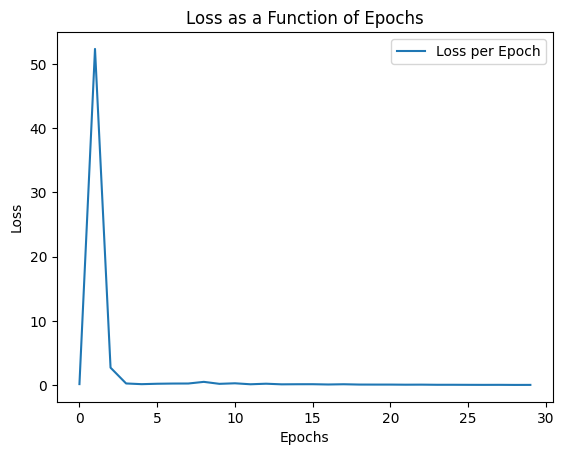

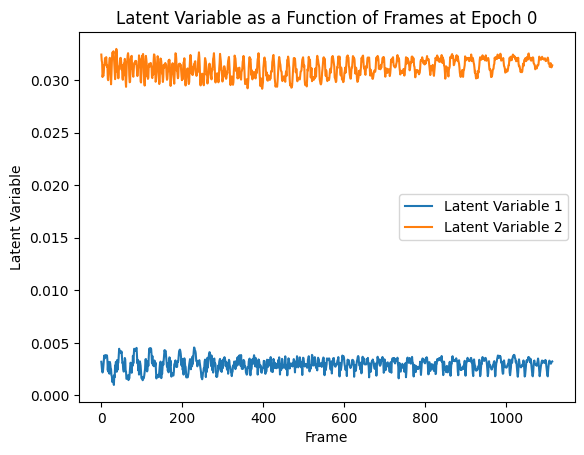

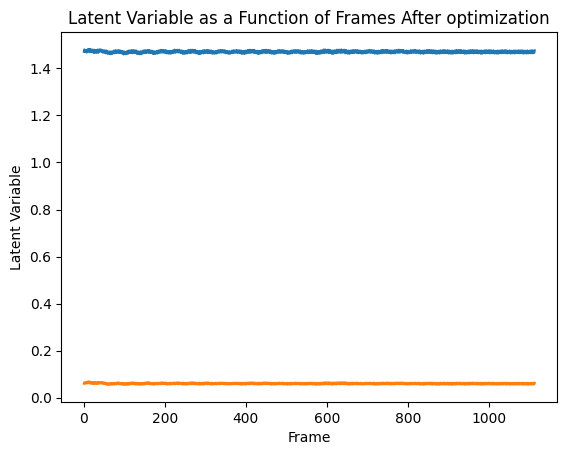

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from data_processing.data_processing2 import images_tensor

class ConvNetAutoencoder_basic(nn.Module):
    def __init__(self, input_shape):
        super(ConvNetAutoencoder_basic, self).__init__()
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )
        # Output Dimension = ((Input dimension +2*padding - kernel_size)/stride) + 1
        # stride is how much we shift after each filter 
        # padding is adding zeros around the edges of your matrix before applying the filter
        # Final dimension is (64,69,25)

        #Dynamically calculate the output shape of the encoder conv layers
        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2),  # Assuming a 2-dimensional latent space
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def _get_conv_output(self, shape):
        bs = 1  # Batch size of 1 for testing output shape
        input_tensor = torch.randn(bs, *shape)  # Generate a random tensor without Variable
        with torch.no_grad():  # Disable gradient tracking since this is only for shape calculation
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]  # Store the shape after the last conv layer
        n_size = output_feat.detach().flatten(start_dim=1).size(1)  # Compute flattened size safely
        self.num_flat_features = n_size

    def forward(self, x):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1) #Flattening
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()  # Store latent variables before decoding
        x = self.decoder_fc_layers(x)
        #Use stored shape for dynamic reshaping
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        return x,latent_vars


images_tensor = images_tensor


model = ConvNetAutoencoder_basic(input_shape=(1, 200, 560))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
losses = []
patience = 20
min_delta = 0.01  
latent_epoch_data = []
converged = False


def physics_informed_loss(x, v, lambda_phys=0.5):
    # Example: Assume v should be the derivative of x with respect to some time factor
    # Here we use a simple finite difference approximation (x[n+1] - x[n]) as a placeholder.
    # You can modify this according to the actual physical relation you need to enforce.
    dx_dt_estimated = x[1:] - x[:-1]  # Simple finite difference
    phys_loss = F.mse_loss(v[:-1], dx_dt_estimated)  # MSE between estimated derivative and velocity
    return lambda_phys * phys_loss

for epoch in range(num_epochs):
    if converged:
        break
    model.train()
    optimizer.zero_grad()

    # Forward pass through the model
    reconstructed, latent_vars = model(images_tensor)

    # Standard reconstruction loss
    reconstruction_loss = loss_fn(reconstructed, images_tensor)

    # Extract latent variables assumed as [x, v]
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    # Calculate the physics-informed loss
    phys_loss = physics_informed_loss(x, v)

    # Total loss is the sum of reconstruction loss and physics-informed loss
    total_loss = 0.5*reconstruction_loss + phys_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    losses.append(total_loss.item())
    print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.4f}")

    # Early stopping logic
    if epoch > 0 and (losses[-2] - losses[-1] < min_delta):
        if patience > 0:
            patience -= 1
        else:
            print("Early stopping as the model has converged.")
            converged = True

    if epoch % 50 == 0:
        latent_epoch_data.append(latent_vars.detach().cpu().numpy())



latent_values = []

model.eval()
# Forward pass to get the latent variable
with torch.no_grad():
    xe = model.encoder_conv_layers(images_tensor)
    xe = xe.view(xe.size(0), -1)
    latent_variable = model.encoder_fc_layers(xe)

# Convert the lists to numpy arrays for plotting
latent_values = latent_variable.numpy() 


plt.plot(losses, label='Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as a Function of Epochs')
plt.legend()
plt.show()


for index, latent_vars_at_epoch in enumerate(latent_epoch_data):
    plt.figure()
    for var_idx in range(latent_vars_at_epoch.shape[1]):  
        plt.plot(latent_vars_at_epoch[:, var_idx], label=f'Latent Variable {var_idx + 1}')
    plt.xlabel('Frame')
    plt.ylabel('Latent Variable')
    plt.title(f'Latent Variable as a Function of Frames at Epoch {index * 50}')
    plt.legend()
    plt.show()



# Plot the latent variable as a function of epochs
plt.plot(latent_values)
plt.xlabel('Frame')
plt.ylabel('Latent Variable')
plt.title('Latent Variable as a Function of Frames After optimization')
plt.show()



Expected Shape: [num_frames, 1, 200, 560]
Actual Shape: torch.Size([1114, 1, 200, 560])
Epoch: 0, Total Loss: 0.2867
Epoch: 1, Total Loss: 36.3196
Epoch: 2, Total Loss: 0.6525
Epoch: 3, Total Loss: 0.3491
Epoch: 4, Total Loss: 0.3892
Epoch: 5, Total Loss: 0.3222
Epoch: 6, Total Loss: 0.2384
Epoch: 7, Total Loss: 0.3591
Epoch: 8, Total Loss: 0.6214
Epoch: 9, Total Loss: 0.3633
Epoch: 10, Total Loss: 0.1495
Epoch: 11, Total Loss: 0.2122
Epoch: 12, Total Loss: 0.2224
Epoch: 13, Total Loss: 0.1590
Epoch: 14, Total Loss: 0.1005
Epoch: 15, Total Loss: 0.0794
Epoch: 16, Total Loss: 0.0796
Epoch: 17, Total Loss: 0.0848
Epoch: 18, Total Loss: 0.0820
Epoch: 19, Total Loss: 0.0692
Epoch: 20, Total Loss: 0.0535
Epoch: 21, Total Loss: 0.0430
Epoch: 22, Total Loss: 0.0412
Epoch: 23, Total Loss: 0.0444
Epoch: 24, Total Loss: 0.0453
Epoch: 25, Total Loss: 0.0401
Epoch: 26, Total Loss: 0.0310
Epoch: 27, Total Loss: 0.0227
Epoch: 28, Total Loss: 0.0186
Epoch: 29, Total Loss: 0.0186


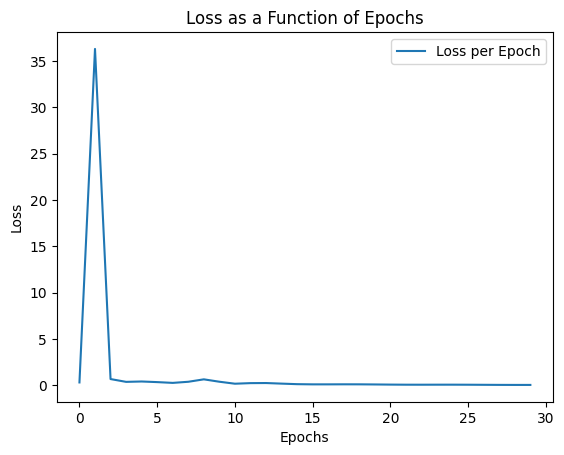

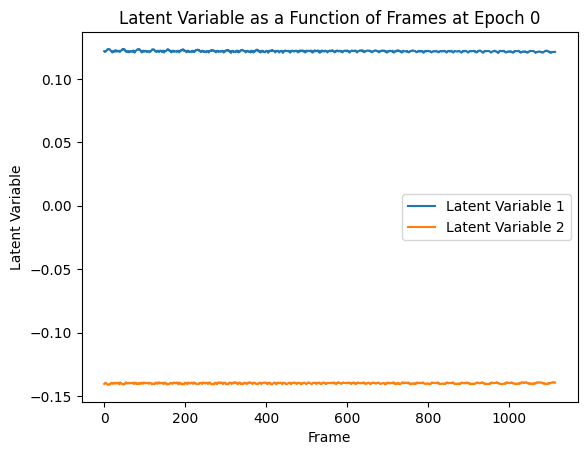

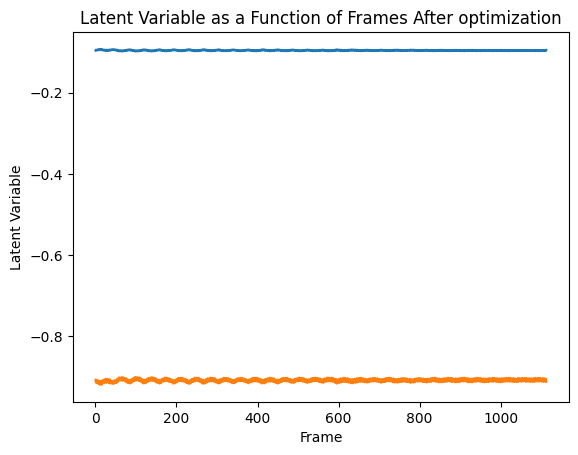

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from data_processing.data_processing2 import images_tensor

class ConvNetAutoencoder_basic(nn.Module):
    def __init__(self, input_shape):
        super(ConvNetAutoencoder_basic, self).__init__()
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )
        # Output Dimension = ((Input dimension +2*padding - kernel_size)/stride) + 1
        # stride is how much we shift after each filter 
        # padding is adding zeros around the edges of your matrix before applying the filter
        # Final dimension is (64,69,25)

        #Dynamically calculate the output shape of the encoder conv layers
        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2),  # Assuming a 2-dimensional latent space
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def _get_conv_output(self, shape):
        bs = 1  # Batch size of 1 for testing output shape
        input_tensor = torch.randn(bs, *shape)  # Generate a random tensor without Variable
        with torch.no_grad():  # Disable gradient tracking since this is only for shape calculation
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]  # Store the shape after the last conv layer
        n_size = output_feat.detach().flatten(start_dim=1).size(1)  # Compute flattened size safely
        self.num_flat_features = n_size

    def forward(self, x):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1) #Flattening
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()  # Store latent variables before decoding
        x = self.decoder_fc_layers(x)
        #Use stored shape for dynamic reshaping
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        return x,latent_vars


images_tensor = images_tensor


model = ConvNetAutoencoder_basic(input_shape=(1, 200, 560))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
losses = []
patience = 20
min_delta = 0.01  
latent_epoch_data = []
converged = False


def physics_informed_loss(x, v, lambda_phys=0.5):
    # Example: Assume v should be the derivative of x with respect to some time factor
    # Here we use a simple finite difference approximation (x[n+1] - x[n]) as a placeholder.
    # You can modify this according to the actual physical relation you need to enforce.
    dx_dt_estimated = x[1:] - x[:-1]  # Simple finite difference
    phys_loss = F.mse_loss(v[:-1], dx_dt_estimated)  # MSE between estimated derivative and velocity
    return lambda_phys * phys_loss

for epoch in range(num_epochs):
    if converged:
        break
    model.train()
    optimizer.zero_grad()

    # Forward pass through the model
    reconstructed, latent_vars = model(images_tensor)

    # Standard reconstruction loss
    reconstruction_loss = loss_fn(reconstructed, images_tensor)

    # Extract latent variables assumed as [x, v]
    v, x = latent_vars[:, 0], latent_vars[:, 1]

    # Calculate the physics-informed loss
    phys_loss = physics_informed_loss(x, v)

    # Total loss is the sum of reconstruction loss and physics-informed loss
    total_loss = 0.5*reconstruction_loss + phys_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    losses.append(total_loss.item())
    print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.4f}")

    # Early stopping logic
    if epoch > 0 and (losses[-2] - losses[-1] < min_delta):
        if patience > 0:
            patience -= 1
        else:
            print("Early stopping as the model has converged.")
            converged = True

    if epoch % 50 == 0:
        latent_epoch_data.append(latent_vars.detach().cpu().numpy())



latent_values = []

model.eval()
# Forward pass to get the latent variable
with torch.no_grad():
    xe = model.encoder_conv_layers(images_tensor)
    xe = xe.view(xe.size(0), -1)
    latent_variable = model.encoder_fc_layers(xe)

# Convert the lists to numpy arrays for plotting
latent_values = latent_variable.numpy() 


plt.plot(losses, label='Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as a Function of Epochs')
plt.legend()
plt.show()


for index, latent_vars_at_epoch in enumerate(latent_epoch_data):
    plt.figure()
    for var_idx in range(latent_vars_at_epoch.shape[1]):  
        plt.plot(latent_vars_at_epoch[:, var_idx], label=f'Latent Variable {var_idx + 1}')
    plt.xlabel('Frame')
    plt.ylabel('Latent Variable')
    plt.title(f'Latent Variable as a Function of Frames at Epoch {index * 50}')
    plt.legend()
    plt.show()



# Plot the latent variable as a function of epochs
plt.plot(latent_values)
plt.xlabel('Frame')
plt.ylabel('Latent Variable')
plt.title('Latent Variable as a Function of Frames After optimization')
plt.show()



Here I am flipping the latent variables

before we try adding another physics loss i will try reducing the learning rate

Epoch: 0, Total Loss: 0.2259
Epoch: 1, Total Loss: 1.1805
Epoch: 2, Total Loss: 0.3286
Epoch: 3, Total Loss: 0.3607
Epoch: 4, Total Loss: 0.4855
Epoch: 5, Total Loss: 0.3975
Epoch: 6, Total Loss: 0.2823
Epoch: 7, Total Loss: 0.2253
Epoch: 8, Total Loss: 0.2262
Epoch: 9, Total Loss: 0.2512
Epoch: 10, Total Loss: 0.2719
Epoch: 11, Total Loss: 0.2763
Epoch: 12, Total Loss: 0.2666
Epoch: 13, Total Loss: 0.2502
Epoch: 14, Total Loss: 0.2343
Epoch: 15, Total Loss: 0.2229
Epoch: 16, Total Loss: 0.2177
Epoch: 17, Total Loss: 0.2177
Epoch: 18, Total Loss: 0.2209
Epoch: 19, Total Loss: 0.2249
Epoch: 20, Total Loss: 0.2280
Epoch: 21, Total Loss: 0.2292
Epoch: 22, Total Loss: 0.2283
Epoch: 23, Total Loss: 0.2257
Epoch: 24, Total Loss: 0.2221
Epoch: 25, Total Loss: 0.2184
Epoch: 26, Total Loss: 0.2151
Epoch: 27, Total Loss: 0.2127
Epoch: 28, Total Loss: 0.2113
Early stopping as the model has converged.


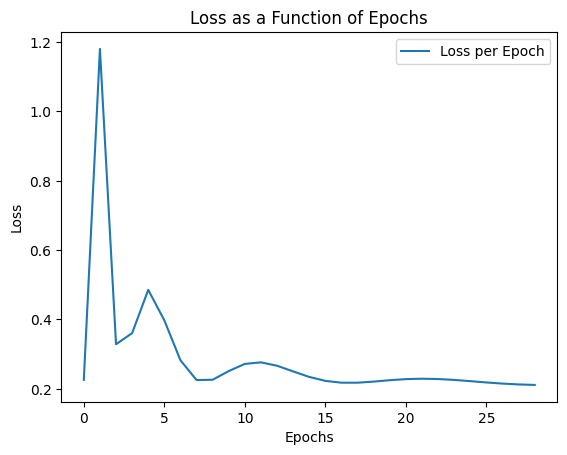

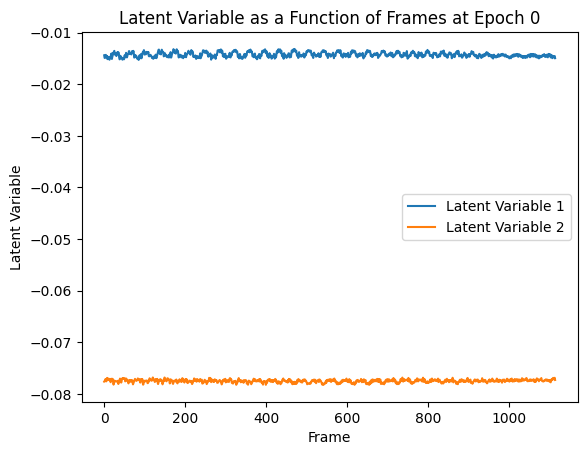

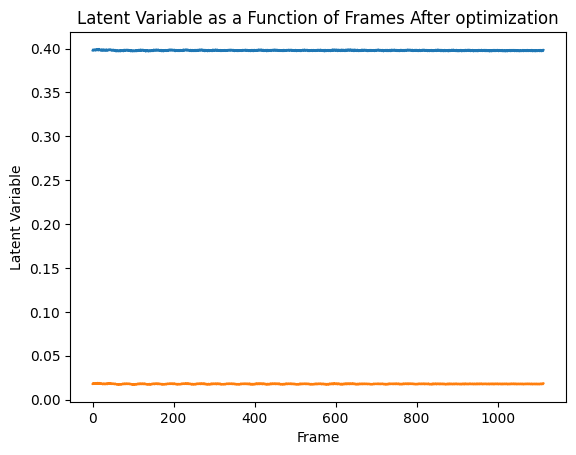

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from data_processing.data_processing2 import images_tensor

class ConvNetAutoencoder_basic(nn.Module):
    def __init__(self, input_shape):
        super(ConvNetAutoencoder_basic, self).__init__()
        self.encoder_conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )
        # Output Dimension = ((Input dimension +2*padding - kernel_size)/stride) + 1
        # stride is how much we shift after each filter 
        # padding is adding zeros around the edges of your matrix before applying the filter
        # Final dimension is (64,69,25)

        #Dynamically calculate the output shape of the encoder conv layers
        self._get_conv_output(input_shape)

        self.encoder_fc_layers = nn.Sequential(
            nn.Linear(self.num_flat_features, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 2),  # Assuming a 2-dimensional latent space
        )

        self.decoder_fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, self.num_flat_features),
        )

        self.decoder_conv_layers = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def _get_conv_output(self, shape):
        bs = 1  # Batch size of 1 for testing output shape
        input_tensor = torch.randn(bs, *shape)  # Generate a random tensor without Variable
        with torch.no_grad():  # Disable gradient tracking since this is only for shape calculation
            output_feat = self.encoder_conv_layers(input_tensor)
        self.final_conv_shape = output_feat.shape[1:]  # Store the shape after the last conv layer
        n_size = output_feat.detach().flatten(start_dim=1).size(1)  # Compute flattened size safely
        self.num_flat_features = n_size

    def forward(self, x):
        x = self.encoder_conv_layers(x)
        x = x.view(x.size(0), -1) #Flattening
        x = self.encoder_fc_layers(x)
        latent_vars = x.clone()  # Store latent variables before decoding
        x = self.decoder_fc_layers(x)
        #Use stored shape for dynamic reshaping
        x = x.view(x.size(0), *self.final_conv_shape)
        x = self.decoder_conv_layers(x)
        return x,latent_vars


images_tensor = images_tensor


model = ConvNetAutoencoder_basic(input_shape=(1, 200, 560))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 30
losses = []
patience = 20
min_delta = 0.01  
latent_epoch_data = []
converged = False


def physics_informed_loss(x, v, lambda_phys=0.5):
    # Example: Assume v should be the derivative of x with respect to some time factor
    # Here we use a simple finite difference approximation (x[n+1] - x[n]) as a placeholder.
    # You can modify this according to the actual physical relation you need to enforce.
    dx_dt_estimated = x[1:] - x[:-1]  # Simple finite difference
    phys_loss = F.mse_loss(v[:-1], dx_dt_estimated)  # MSE between estimated derivative and velocity
    return lambda_phys * phys_loss

for epoch in range(num_epochs):
    if converged:
        break
    model.train()
    optimizer.zero_grad()

    # Forward pass through the model
    reconstructed, latent_vars = model(images_tensor)

    # Standard reconstruction loss
    reconstruction_loss = loss_fn(reconstructed, images_tensor)

    # Extract latent variables assumed as [x, v]
    x, v = latent_vars[:, 0], latent_vars[:, 1]

    # Calculate the physics-informed loss
    phys_loss = physics_informed_loss(x, v)

    # Total loss is the sum of reconstruction loss and physics-informed loss
    total_loss = 0.5*reconstruction_loss + phys_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    losses.append(total_loss.item())
    print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.4f}")

    # Early stopping logic
    if epoch > 0 and (losses[-2] - losses[-1] < min_delta):
        if patience > 0:
            patience -= 1
        else:
            print("Early stopping as the model has converged.")
            converged = True

    if epoch % 50 == 0:
        latent_epoch_data.append(latent_vars.detach().cpu().numpy())



latent_values = []

model.eval()
# Forward pass to get the latent variable
with torch.no_grad():
    xe = model.encoder_conv_layers(images_tensor)
    xe = xe.view(xe.size(0), -1)
    latent_variable = model.encoder_fc_layers(xe)

# Convert the lists to numpy arrays for plotting
latent_values = latent_variable.numpy() 


plt.plot(losses, label='Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss as a Function of Epochs')
plt.legend()
plt.show()


for index, latent_vars_at_epoch in enumerate(latent_epoch_data):
    plt.figure()
    for var_idx in range(latent_vars_at_epoch.shape[1]):  
        plt.plot(latent_vars_at_epoch[:, var_idx], label=f'Latent Variable {var_idx + 1}')
    plt.xlabel('Frame')
    plt.ylabel('Latent Variable')
    plt.title(f'Latent Variable as a Function of Frames at Epoch {index * 50}')
    plt.legend()
    plt.show()



# Plot the latent variable as a function of epochs
plt.plot(latent_values)
plt.xlabel('Frame')
plt.ylabel('Latent Variable')
plt.title('Latent Variable as a Function of Frames After optimization')
plt.show()



This did worse so now let us try to find the actual v and x of the system using data processing and add physics informed losses using actual values

2025-04-02 22:00:36.594 Python[3233:157790] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-02 22:00:36.594 Python[3233:157790] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Reference point selected at: (399, 84)
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Measured rod length in pixels: 46.87


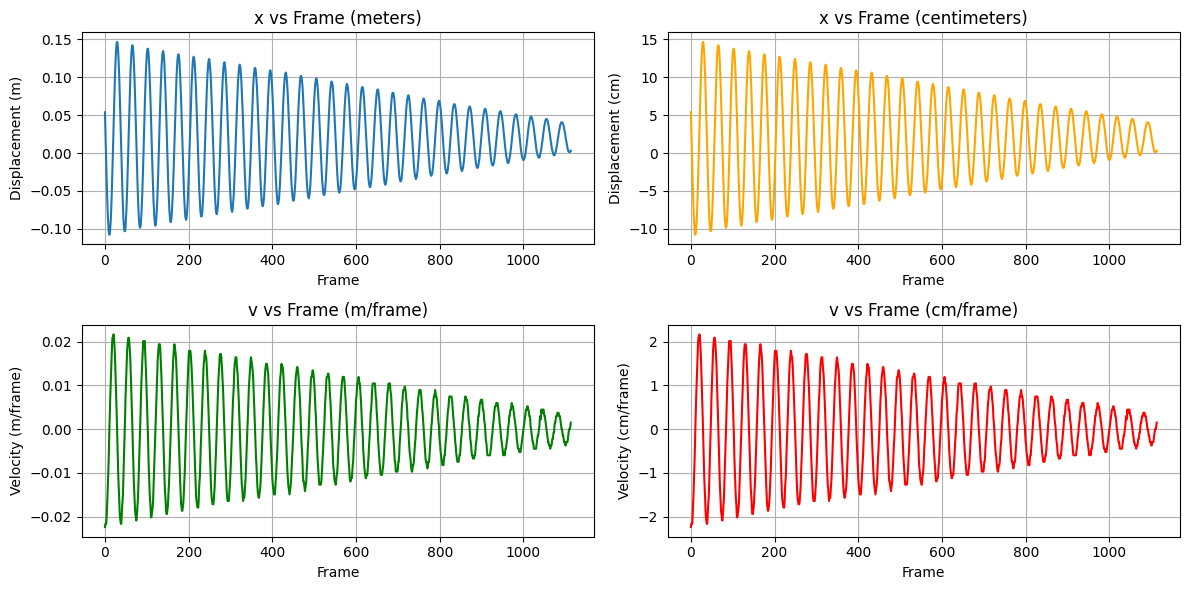

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

video_path = '/Users/karim/desktop/eece499/spring-osc-trim.mov'


# === STEP 1: Select reference point (x = 0) ===
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
if not ret:
    raise ValueError("Failed to read first frame.")

ref_point = []

def select_reference(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        ref_point.clear()
        ref_point.append((x, y))
        print(f"Reference point selected at: ({x}, {y})")
        cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow("Select Reference", frame)

cv2.imshow("Select Reference", frame)
cv2.setMouseCallback("Select Reference", select_reference)
cv2.waitKey(0)
cv2.destroyAllWindows()

if not ref_point:
    raise ValueError("No reference point selected.")
ref_x = ref_point[0][0]
ref_y = ref_point[0][1]

# === STEP 2: Select rod template for tracking ===
roi = cv2.selectROI("Select Rod Template", frame, fromCenter=False, showCrosshair=True)
cv2.destroyAllWindows()
x, y, w, h = map(int, roi)
template = frame[y:y+h, x:x+w]
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

# === STEP 3: Measure rod length in pixels (click both ends) ===
ret, frame = cap.read()
points = []

def click_ends(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        cv2.circle(frame, (x, y), 5, (255, 0, 0), -1)
        cv2.imshow("Click Ends of Rod (for scale)", frame)

cv2.imshow("Click Ends of Rod (for scale)", frame)
cv2.setMouseCallback("Click Ends of Rod (for scale)", click_ends)
cv2.waitKey(0)
cv2.destroyAllWindows()

if len(points) != 2:
    raise ValueError("You must click exactly two points on the rod.")
rod_px_length = np.linalg.norm(np.array(points[0]) - np.array(points[1]))
print(f"Measured rod length in pixels: {rod_px_length:.2f}")

# === STEP 4: Input real rod length ===
real_rod_cm = 7
scale_cm = real_rod_cm / rod_px_length
scale_m = scale_cm / 100

# === STEP 5: Template match frame-by-frame ===
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
dt = 1.0 / fps

positions = []
times = []
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    result = cv2.matchTemplate(gray, template_gray, cv2.TM_CCOEFF_NORMED)
    _, _, _, max_loc = cv2.minMaxLoc(result)
    top_left = max_loc
    center_x = top_left[0] + w // 2
    center_y = top_left[1] + h // 2

    displacement_px = center_x - ref_x
    positions.append(displacement_px)
    times.append(frame_idx * dt)

    # Show tracking (optional)
    cv2.circle(frame, (center_x, center_y), 5, (0, 0, 255), -1)
    cv2.circle(frame, (ref_x, ref_y), 5, (0, 255, 0), -1)
    cv2.putText(frame, f"x: {displacement_px}px", (center_x + 10, center_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    cv2.imshow("Rod Tracking", frame)

    if cv2.waitKey(int(1000 / fps)) & 0xFF == ord('q'):
        break

    frame_idx += 1


cap.release()
cv2.destroyAllWindows()
for _ in range(5):  # Give the system time to flush GUI events
    cv2.waitKey(1)


# === STEP 6: Convert to SI Units ===
positions = np.array(positions)
positions_m = positions * scale_m
positions_cm = positions * scale_cm

vel_m_per_frame = np.gradient(positions_m)
vel_cm_per_frame = np.gradient(positions_cm)

frame_indices = np.arange(len(positions))

# === STEP 7: Plot ===
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(frame_indices, positions_m)
plt.title("x vs Frame (meters)")
plt.xlabel("Frame")
plt.ylabel("Displacement (m)")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(frame_indices, positions_cm, color='orange')
plt.title("x vs Frame (centimeters)")
plt.xlabel("Frame")
plt.ylabel("Displacement (cm)")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(frame_indices, vel_m_per_frame, color='green')
plt.title("v vs Frame (m/frame)")
plt.xlabel("Frame")
plt.ylabel("Velocity (m/frame)")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(frame_indices, vel_cm_per_frame, color='red')
plt.title("v vs Frame (cm/frame)")
plt.xlabel("Frame")
plt.ylabel("Velocity (cm/frame)")
plt.grid(True)

plt.tight_layout()
plt.show()



[36 21  7 ...  1  1  2]
